In [32]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report
from typing import List, Dict, Tuple, Optional, Callable
from dataclasses import dataclass
from CNN import Conv2D, MaxPool2D, AvgPool2D, Flatten, ReLU, CNNFromScratch
import gc

In [33]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [34]:
def reset_tensorflow():
    """Reset TensorFlow session"""
    try:
        tf.keras.backend.clear_session()
        print("TensorFlow session cleared")
    except Exception as e:
        print(f"Error clearing TensorFlow session: {e}")

In [35]:
@dataclass
class ExperimentConfig:
    name: str
    conv_layers: List[int]  # Number of filters per conv layer
    kernel_sizes: List[int]  # Kernel size per conv layer
    pooling_type: str  # 'max' or 'avg'

config = ExperimentConfig("check_forward", [32, 64, 128], [3, 3, 3], "max")

In [36]:
results = {}
models = {}
pooling_type = ""

In [37]:
def load_and_prepare_data():
    """Load CIFAR-10 and create train/val/test splits"""
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    
    # Normalize pixel values
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Flatten labels
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    # Split training data into train/validation (4:1 ratio)
    train_size = int(0.8 * len(x_train))  # 40k train, 10k validation
    
    # Shuffle before splitting
    indices = np.random.permutation(len(x_train))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    x_train_final = x_train[train_indices]
    y_train_final = y_train[train_indices]
    x_val = x_train[val_indices]
    y_val = y_train[val_indices]
    
    print(f"Training set: {x_train_final.shape[0]} samples")
    print(f"Validation set: {x_val.shape[0]} samples")
    print(f"Test set: {x_test.shape[0]} samples")
    
    return (x_train_final, y_train_final), (x_val, y_val), (x_test, y_test)

train_data, val_data, test_data = load_and_prepare_data()
x_train, y_train = train_data
x_val, y_val = val_data
x_test, y_test = test_data

Training set: 40000 samples
Validation set: 10000 samples
Test set: 10000 samples


In [38]:
def create_cnn_model(config: ExperimentConfig, input_shape=(32, 32, 3)):
    """Create CNN model based on configuration"""
    model = keras.Sequential()
    
    # Add convolutional layers
    for i, (filters, kernel_size) in enumerate(zip(config.conv_layers, config.kernel_sizes)):
        if i == 0:
            model.add(keras.layers.Conv2D(filters, kernel_size, activation='relu', 
                                        input_shape=input_shape, padding='same'))
        else:
            model.add(keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same'))
            
        # Add pooling layer after each conv layer
        if config.pooling_type == 'max':
            model.add(keras.layers.MaxPooling2D(2, 2))
        else:
            model.add(keras.layers.AveragePooling2D(2, 2))
            
    # Add classification head
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    
    return model

model = create_cnn_model(config)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

def train_model(model, train_data, val_data, epochs=20, batch_size=32):
    """Train the model"""
    x_train, y_train = train_data
    x_val, y_val = val_data
    
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stop, lr_schedule],
                        verbose=1)
    
    return history

history = train_model(model, train_data, val_data, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4680 - accuracy: 0.4638 - val_loss: 1.1411 - val_accuracy: 0.5965 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.0296 - accuracy: 0.6352 - val_loss: 0.9707 - val_accuracy: 0.6632 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8462 - accuracy: 0.7035 - val_loss: 0.8690 - val_accuracy: 0.6997 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7253 - accuracy: 0.7433 - val_loss: 0.8560 - val_accuracy: 0.7074 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6285 - accuracy: 0.7788 - val_loss: 0.8438 - val_accuracy: 0.7152 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5445 - accuracy: 0.8092 - val_loss: 0.8691 - val_accuracy: 0.7052 - lr: 0.0010
Epoch 7/10
1250/1250 [==============================] - 4s

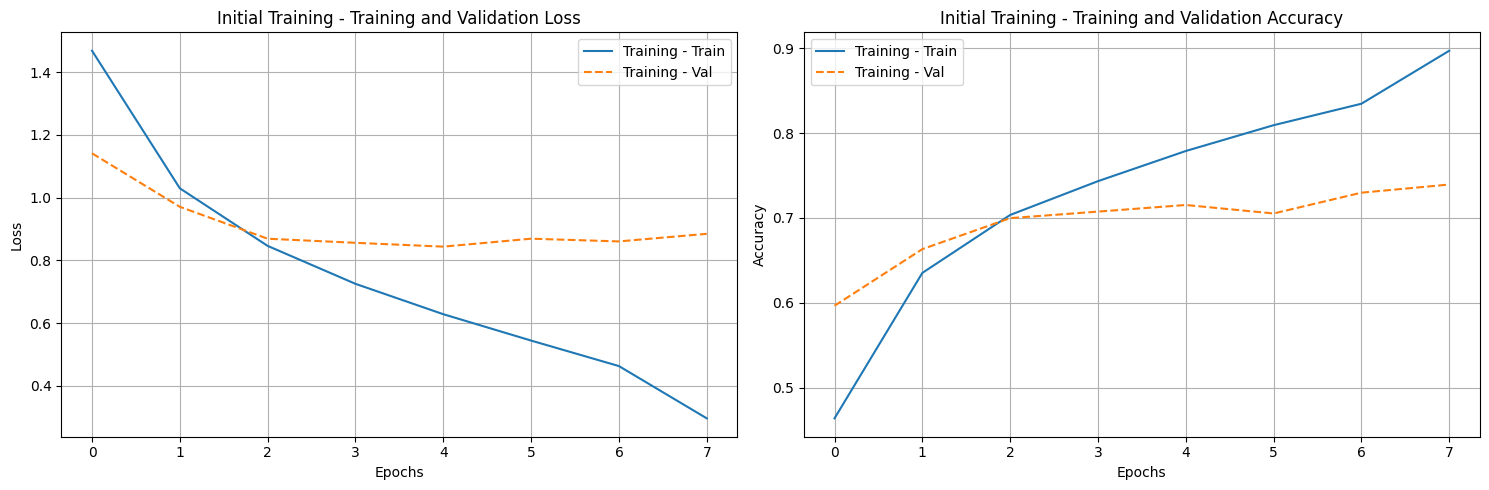

In [40]:
def plot_training_history(histories, title_prefix=""):
    """Plot training and validation loss for multiple experiments"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{name} - Train')
        plt.plot(history.history['val_loss'], label=f'{name} - Val', linestyle='--')
    plt.title(f'{title_prefix} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{name} - Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} - Val', linestyle='--')
    plt.title(f'{title_prefix} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history({"Training" : history}, "Initial Training")

In [41]:
def test_from_scratch_implementation(keras_model, test_data, model_config):
    """Test the from-scratch implementation against Keras"""
    print("\n=== Testing From-Scratch Implementation ===")
    
    x_test, y_test = test_data
    
    # Create from-scratch model
    scratch_model = CNNFromScratch()
    
    # Add convolutional and pooling layers based on config
    for i, (filters, kernel_size) in enumerate(zip(model_config.conv_layers, model_config.kernel_sizes)):
        scratch_model.add_layer(Conv2D(filters, kernel_size, padding='same'))
        if model_config.pooling_type == 'max':
            scratch_model.add_layer(MaxPool2D(2, 2))
        else:
            scratch_model.add_layer(AvgPool2D(2, 2))
    
    # Add flatten layer
    scratch_model.add_layer(Flatten())
    
    # Calculate the correct flattened size
    input_shape = (32, 32, 3)  # CIFAR-10 image shape
    flattened_size = scratch_model.calculate_flattened_size(
        input_shape, model_config.conv_layers, model_config.kernel_sizes, model_config.pooling_type
    )
    
    print(f"Calculated flattened size: {flattened_size}")
    
    from Layer import Layer
    from activation import relu, softmax
    
    # Create dense layers with correct input sizes
    dense1 = Layer(flattened_size, 128, activation=relu)
    dense2 = Layer(128, 10, activation=softmax)
    
    scratch_model.add_layer(dense1)
    scratch_model.add_layer(dense2)
    
    # Load weights from Keras model
    try:
        scratch_model.load_keras_weights(keras_model)
        print("Successfully loaded weights from Keras model")
    except Exception as e:
        print(f"Error loading weights: {e}")
        return None, None
    
    # Test on a small batch first to verify implementation
    batch_size = 100
    x_batch = x_test[:batch_size]
    y_batch = y_test[:batch_size]
    
    print(f"Testing on batch of {batch_size} samples...")
    
    try:
        # Keras predictions
        keras_pred = keras_model.predict(x_batch, verbose=0)
        keras_pred_classes = np.argmax(keras_pred, axis=1)
        
        # From-scratch predictions
        scratch_pred = scratch_model.predict(x_batch)
        
        # Handle potential shape issues
        if scratch_pred.ndim == 1:
            scratch_pred = scratch_pred.reshape(batch_size, -1)
        
        scratch_pred_classes = np.argmax(scratch_pred, axis=1)
        
        # Compare results
        keras_f1 = f1_score(y_batch, keras_pred_classes, average='macro')
        scratch_f1 = f1_score(y_batch, scratch_pred_classes, average='macro')
        
        print(f"Keras Model F1-Score: {keras_f1:.4f}")
        print(f"From-Scratch Model F1-Score: {scratch_f1:.4f}")
        print(f"Difference: {abs(keras_f1 - scratch_f1):.4f}")
        
        # Check if predictions are similar
        matching_predictions = np.sum(keras_pred_classes == scratch_pred_classes)
        match_percentage = matching_predictions/batch_size*100
        print(f"Matching predictions: {matching_predictions}/{batch_size} ({match_percentage:.2f}%)")
        
        # Additional debugging information
        print(f"Keras predictions shape: {keras_pred.shape}")
        print(f"Scratch predictions shape: {scratch_pred.shape}")
        print(f"Sample keras prediction: {keras_pred[0][:5]}")
        print(f"Sample scratch prediction: {scratch_pred[0][:5]}")
        
        # Test on full test set if small batch works well
        if match_percentage > 90:  # If more than 90% match, test on full set
            print("\nTesting on full test set...")
            keras_pred_full = keras_model.predict(x_test, verbose=0)
            keras_pred_classes_full = np.argmax(keras_pred_full, axis=1)
            
            scratch_pred_full = scratch_model.predict(x_test)
            if scratch_pred_full.ndim == 1:
                scratch_pred_full = scratch_pred_full.reshape(len(x_test), -1)
            scratch_pred_classes_full = np.argmax(scratch_pred_full, axis=1)
            
            keras_f1_full = f1_score(y_test, keras_pred_classes_full, average='macro')
            scratch_f1_full = f1_score(y_test, scratch_pred_classes_full, average='macro')
            
            print(f"Full Test Set:")
            print(f"Keras Model F1-Score: {keras_f1_full:.4f}")
            print(f"From-Scratch Model F1-Score: {scratch_f1_full:.4f}")
            print(f"Difference: {abs(keras_f1_full - scratch_f1_full):.4f}")
            
            return keras_f1_full, scratch_f1_full
        
        return keras_f1, scratch_f1
        
    except Exception as e:
        print(f"Error during prediction comparison: {e}")
        import traceback
        traceback.print_exc()
        return None, None
    
test_from_scratch_implementation(model, test_data, config)


=== Testing From-Scratch Implementation ===
Calculated flattened size: 2048
Successfully loaded weights from Keras model
Testing on batch of 100 samples...
Keras Model F1-Score: 0.7818
From-Scratch Model F1-Score: 0.7818
Difference: 0.0000
Matching predictions: 100/100 (100.00%)
Keras predictions shape: (100, 10)
Scratch predictions shape: (100, 10)
Sample keras prediction: [5.6130387e-04 3.1053950e-03 1.5119280e-03 7.6065505e-01 1.1059082e-03]
Sample scratch prediction: [5.6154048e-04 3.1041398e-03 1.5111318e-03 7.6066703e-01 1.1047955e-03]

Testing on full test set...
Full Test Set:
Keras Model F1-Score: 0.7154
From-Scratch Model F1-Score: 0.7154
Difference: 0.0000


(0.7153645530368894, 0.7153645530368894)

In [42]:
def evaluate_model(model, test_data):
    """Evaluate model and return macro F1-score"""
    x_test, y_test = test_data
    
    # Get predictions
    y_pred_proba = model.predict(x_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Calculate macro F1-score
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    return f1_macro, y_pred

TensorFlow session cleared
=== Experiment: Number of Convolutional Layers ===

Training 2_conv_layers...
Epoch 1/15
1250/1250 [==============================] - 9s 7ms/step - loss: 1.4090 - accuracy: 0.4948 - val_loss: 1.1406 - val_accuracy: 0.6001 - lr: 0.0010
Epoch 2/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0432 - accuracy: 0.6324 - val_loss: 1.0352 - val_accuracy: 0.6399 - lr: 0.0010
Epoch 3/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.8866 - accuracy: 0.6872 - val_loss: 0.9356 - val_accuracy: 0.6727 - lr: 0.0010
Epoch 4/15
1250/1250 [==============================] - 8s 6ms/step - loss: 0.7719 - accuracy: 0.7275 - val_loss: 0.9367 - val_accuracy: 0.6735 - lr: 0.0010
Epoch 5/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.6776 - accuracy: 0.7621 - val_loss: 0.9045 - val_accuracy: 0.6878 - lr: 0.0010
Epoch 6/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.5857 - accuracy: 0.7940 - val_lo

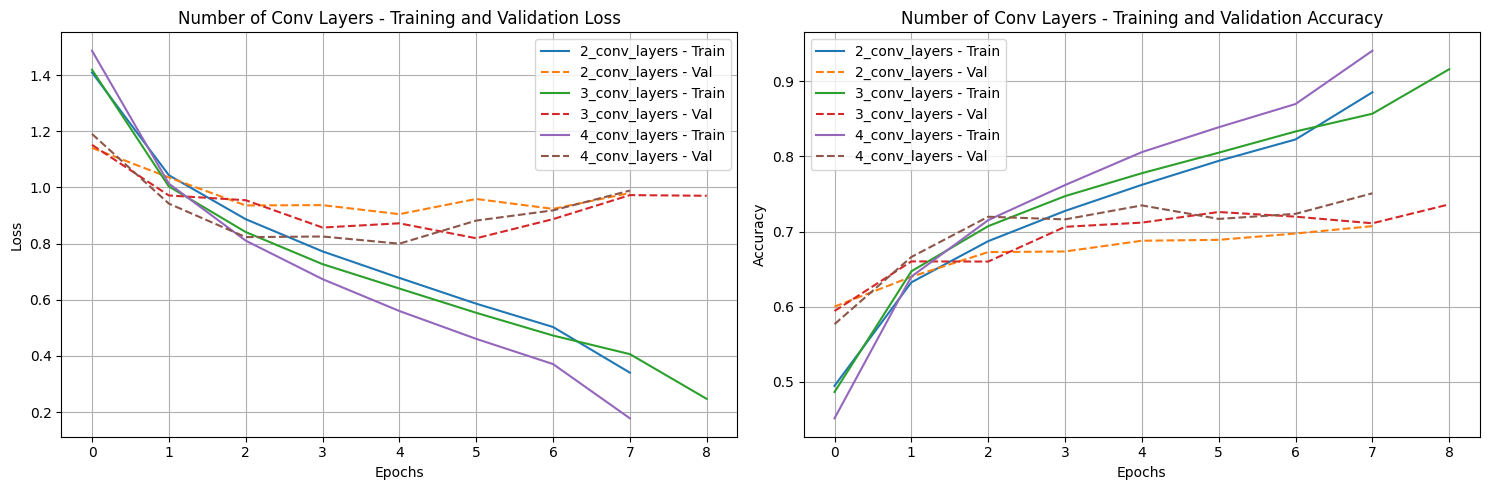


=== Results Summary: Number of Conv Layers ===
2_conv_layers: 0.6929
3_conv_layers: 0.7242
4_conv_layers: 0.7302


In [43]:
def run_conv_layers_experiment(train_data, val_data, test_data):
    """Experiment with different numbers of convolutional layers"""
    print("=== Experiment: Number of Convolutional Layers ===")
    
    configs = [
        ExperimentConfig("2_conv_layers", [32, 64], [3, 3], "max"),
        ExperimentConfig("3_conv_layers", [32, 64, 128], [3, 3, 3], "max"),
        ExperimentConfig("4_conv_layers", [32, 64, 128, 256], [3, 3, 3, 3], "max")
    ]
    
    results = {}
    histories = {}
    models = {}
    
    for config in configs:
        print(f"\nTraining {config.name}...")
        model = create_cnn_model(config)
        history = train_model(model, train_data, val_data, epochs=15)
        f1_score_result, _ = evaluate_model(model, test_data)
        
        results[config.name] = f1_score_result
        histories[config.name] = history
        models[config.name] = model
        
        print(f"{config.name} - Test Macro F1-Score: {f1_score_result:.4f}")
    
    plot_training_history(histories, "Number of Conv Layers")
    
    print("\n=== Results Summary: Number of Conv Layers ===")
    for name, score in results.items():
        print(f"{name}: {score:.4f}")
    
    return results, models

reset_tensorflow()
histories, models = run_conv_layers_experiment(train_data, val_data, test_data)

In [44]:
del histories
del models
reset_tensorflow()
gc.collect()

TensorFlow session cleared


28621


=== Experiment: Number of Filters per Layer ===

Training small_filters...
Epoch 1/15
1250/1250 [==============================] - 11s 8ms/step - loss: 1.4872 - accuracy: 0.4582 - val_loss: 1.2950 - val_accuracy: 0.5427 - lr: 0.0010
Epoch 2/15
1250/1250 [==============================] - 10s 8ms/step - loss: 1.1058 - accuracy: 0.6091 - val_loss: 1.0612 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 3/15
1250/1250 [==============================] - 10s 8ms/step - loss: 0.9532 - accuracy: 0.6657 - val_loss: 0.9849 - val_accuracy: 0.6541 - lr: 0.0010
Epoch 4/15
1250/1250 [==============================] - 10s 8ms/step - loss: 0.8538 - accuracy: 0.7008 - val_loss: 0.9526 - val_accuracy: 0.6666 - lr: 0.0010
Epoch 5/15
1250/1250 [==============================] - 10s 8ms/step - loss: 0.7728 - accuracy: 0.7290 - val_loss: 0.9025 - val_accuracy: 0.6906 - lr: 0.0010
Epoch 6/15
1250/1250 [==============================] - 10s 8ms/step - loss: 0.7046 - accuracy: 0.7530 - val_loss: 0.9523 - val_accura

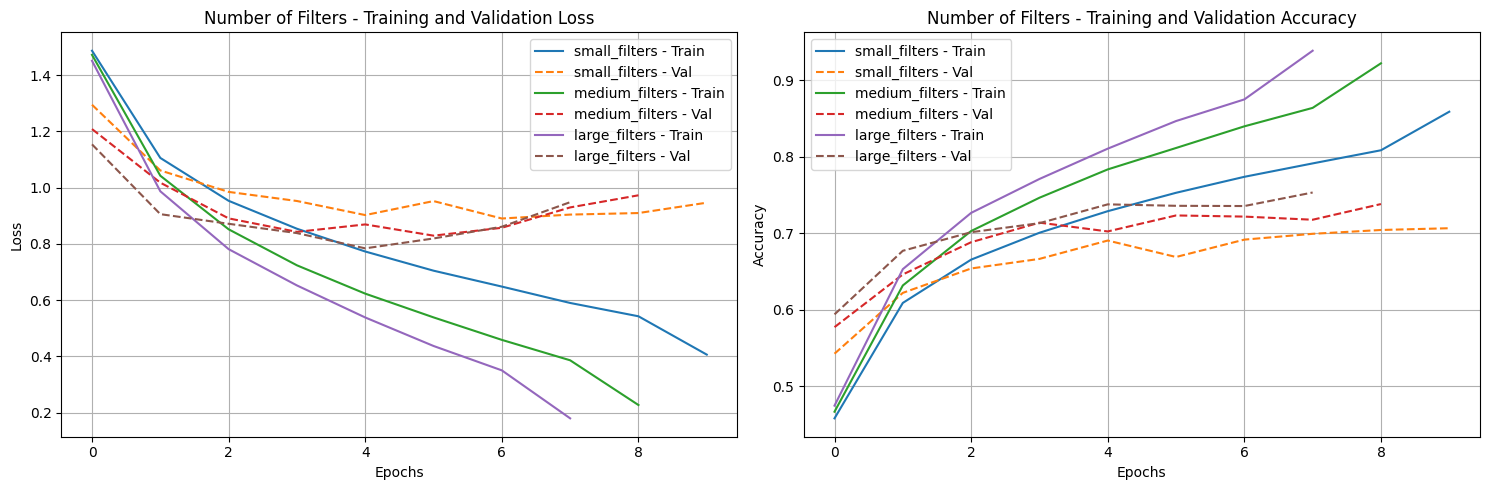


=== Results Summary: Number of Filters ===
small_filters: 0.7010
medium_filters: 0.7356
large_filters: 0.7409


In [45]:
def run_filters_experiment(train_data, val_data, test_data):
    """Experiment with different numbers of filters per layer"""
    print("\n=== Experiment: Number of Filters per Layer ===")
    
    configs = [
        ExperimentConfig("small_filters", [16, 32, 64], [3, 3, 3], "max"),
        ExperimentConfig("medium_filters", [32, 64, 128], [3, 3, 3], "max"),
        ExperimentConfig("large_filters", [64, 128, 256], [3, 3, 3], "max")
    ]
    
    results = {}
    histories = {}
    models = {}
    
    for config in configs:
        print(f"\nTraining {config.name}...")
        model = create_cnn_model(config)
        history = train_model(model, train_data, val_data, epochs=15)
        f1_score_result, _ = evaluate_model(model, test_data)
        
        results[config.name] = f1_score_result
        histories[config.name] = history
        models[config.name] = model
        
        print(f"{config.name} - Test Macro F1-Score: {f1_score_result:.4f}")
    
    plot_training_history(histories, "Number of Filters")
    
    print("\n=== Results Summary: Number of Filters ===")
    for name, score in results.items():
        print(f"{name}: {score:.4f}")
    
    return results, models

histories, models = run_filters_experiment(train_data, val_data, test_data)

In [46]:
del histories
del models
reset_tensorflow()
gc.collect()

TensorFlow session cleared


17532


=== Experiment: Kernel Sizes ===

Training kernel_3x3...
Epoch 1/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4507 - accuracy: 0.4712 - val_loss: 1.1383 - val_accuracy: 0.5936 - lr: 0.0010
Epoch 2/15
1250/1250 [==============================] - 4s 3ms/step - loss: 1.0130 - accuracy: 0.6411 - val_loss: 0.9535 - val_accuracy: 0.6685 - lr: 0.0010
Epoch 3/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8252 - accuracy: 0.7085 - val_loss: 0.8779 - val_accuracy: 0.6960 - lr: 0.0010
Epoch 4/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7164 - accuracy: 0.7496 - val_loss: 0.8300 - val_accuracy: 0.7181 - lr: 0.0010
Epoch 5/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6217 - accuracy: 0.7829 - val_loss: 0.8470 - val_accuracy: 0.7112 - lr: 0.0010
Epoch 6/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5378 - accuracy: 0.8088 - val_loss: 0.9067 - val_accuracy: 0.7034 - lr: 0.0010


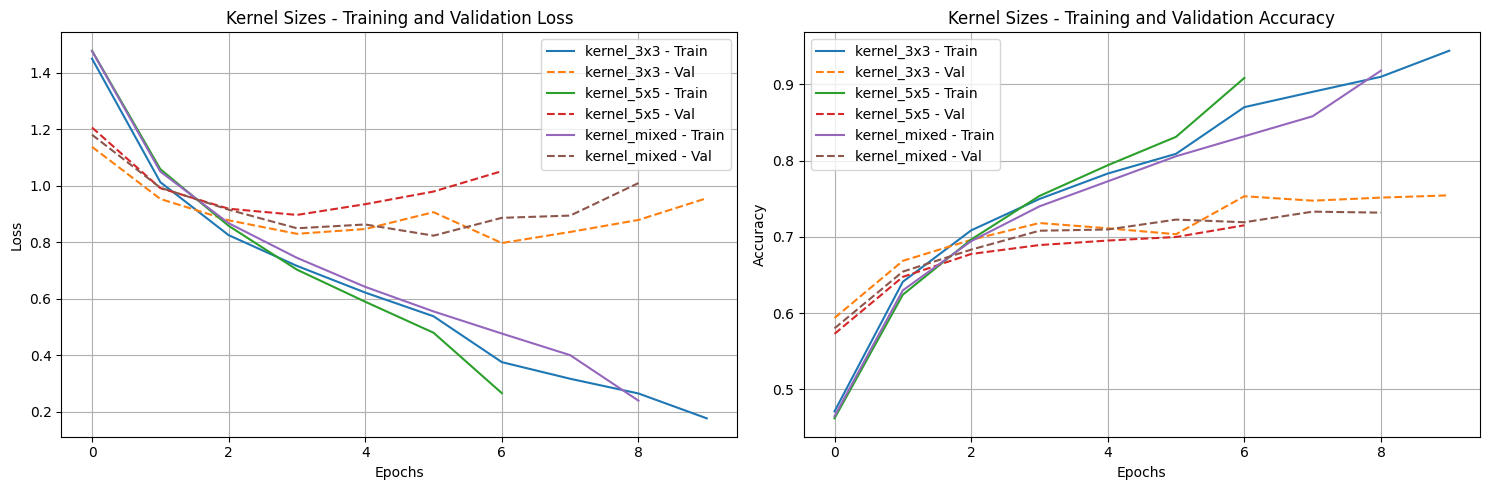


=== Results Summary: Kernel Sizes ===
kernel_3x3: 0.7485
kernel_5x5: 0.6906
kernel_mixed: 0.7244


In [47]:
def run_kernel_size_experiment(train_data, val_data, test_data):
    """Experiment with different kernel sizes"""
    print("\n=== Experiment: Kernel Sizes ===")
    
    configs = [
        ExperimentConfig("kernel_3x3", [32, 64, 128], [3, 3, 3], "max"),
        ExperimentConfig("kernel_5x5", [32, 64, 128], [5, 5, 5], "max"),
        ExperimentConfig("kernel_mixed", [32, 64, 128], [3, 5, 3], "max")
    ]
    
    results = {}
    histories = {}
    models = {}
    
    for config in configs:
        print(f"\nTraining {config.name}...")
        model = create_cnn_model(config)
        history = train_model(model, train_data, val_data, epochs=15)
        f1_score_result, _ = evaluate_model(model, test_data)
        
        results[config.name] = f1_score_result
        histories[config.name] = history
        models[config.name] = model
        
        print(f"{config.name} - Test Macro F1-Score: {f1_score_result:.4f}")
    
    plot_training_history(histories, "Kernel Sizes")
    
    print("\n=== Results Summary: Kernel Sizes ===")
    for name, score in results.items():
        print(f"{name}: {score:.4f}")
    
    return results, models

histories, models = run_kernel_size_experiment(train_data, val_data, test_data)

In [48]:
del histories
del models
reset_tensorflow()
gc.collect()

TensorFlow session cleared


17337


=== Experiment: Pooling Types ===

Training max_pooling...
Epoch 1/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4799 - accuracy: 0.4649 - val_loss: 1.1852 - val_accuracy: 0.5851 - lr: 0.0010
Epoch 2/15
1250/1250 [==============================] - 4s 3ms/step - loss: 1.0308 - accuracy: 0.6363 - val_loss: 0.9600 - val_accuracy: 0.6649 - lr: 0.0010
Epoch 3/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8511 - accuracy: 0.7027 - val_loss: 0.8870 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 4/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7296 - accuracy: 0.7438 - val_loss: 0.8985 - val_accuracy: 0.6893 - lr: 0.0010
Epoch 5/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6414 - accuracy: 0.7735 - val_loss: 0.8095 - val_accuracy: 0.7246 - lr: 0.0010
Epoch 6/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5569 - accuracy: 0.8042 - val_loss: 0.9152 - val_accuracy: 0.7133 - lr: 0.001

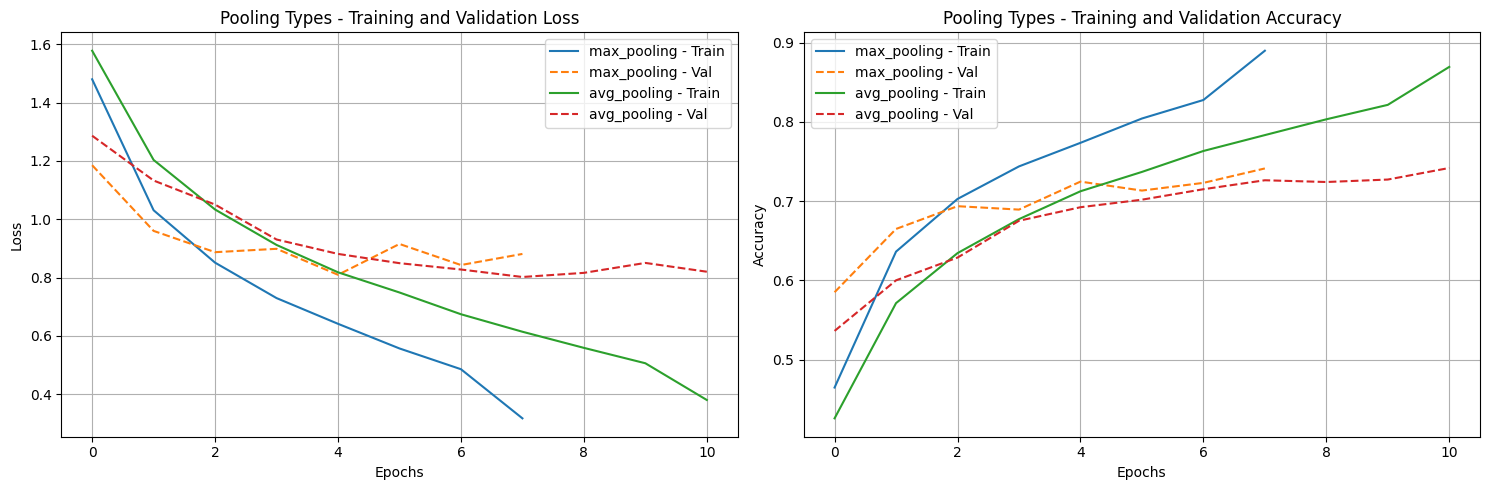


=== Results Summary: Pooling Types ===
max_pooling: 0.7281
avg_pooling: 0.7238


In [49]:
def run_pooling_experiment(train_data, val_data, test_data):
    """Experiment with different pooling types"""
    print("\n=== Experiment: Pooling Types ===")
    
    configs = [
        ExperimentConfig("max_pooling", [32, 64, 128], [3, 3, 3], "max"),
        ExperimentConfig("avg_pooling", [32, 64, 128], [3, 3, 3], "avg")
    ]
    
    results = {}
    histories = {}
    models = {}
    
    for config in configs:
        print(f"\nTraining {config.name}...")
        model = create_cnn_model(config)
        history = train_model(model, train_data, val_data, epochs=15)
        f1_score_result, _ = evaluate_model(model, test_data)
        
        results[config.name] = f1_score_result
        histories[config.name] = history
        models[config.name] = model
        
        print(f"{config.name} - Test Macro F1-Score: {f1_score_result:.4f}")
    
    plot_training_history(histories, "Pooling Types")
    
    print("\n=== Results Summary: Pooling Types ===")
    for name, score in results.items():
        print(f"{name}: {score:.4f}")
    
    return results, models

histories, models = run_pooling_experiment(train_data, val_data, test_data)

In [50]:
del histories
del models
reset_tensorflow()
gc.collect()

TensorFlow session cleared


14099